# First analysis of geographical data

For performance reasons only may data is used.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import folium
from folium import plugins
from folium.plugins import HeatMap

In [2]:
# loading the main dataset

file_path = "C:/Users/Adrian/Documents/Studium/Projekte/DSML Bikesharing/PredictiveStruggle_BikeSharing"
#chicago_data = pd.read_csv("{}chicago_2016.csv".format(file_path), sep=",")

#use the following line only if you want to analyse the weather data as it takes much longer to load
chicago_data = pd.read_csv(file_path+"/chicago_2016.csv", sep=",", parse_dates = ["start_time","end_time"])
chicago_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3595383 entries, 0 to 3595382
Data columns (total 8 columns):
 #   Column              Dtype         
---  ------              -----         
 0   start_time          datetime64[ns]
 1   end_time            datetime64[ns]
 2   start_station_id    int64         
 3   end_station_id      int64         
 4   start_station_name  object        
 5   end_station_name    object        
 6   bike_id             int64         
 7   user_type           object        
dtypes: datetime64[ns](2), int64(3), object(3)
memory usage: 219.4+ MB


In [5]:
chicago_data.head()

,start_time,end_time,start_station_id,end_station_id,start_station_name,end_station_name,bike_id,user_type
0,2016-03-31 23:53:00,2016-04-01 00:07:00,344,458,Ravenswood Ave & Lawrence Ave,Broadway & Thorndale Ave,155,Subscriber
1,2016-03-31 23:46:00,2016-03-31 23:57:00,128,213,Damen Ave & Chicago Ave,Leavitt St & North Ave,4831,Subscriber
2,2016-03-31 23:42:00,2016-03-31 23:46:00,350,210,Ashland Ave & Chicago Ave,Ashland Ave & Division St,4232,Subscriber
3,2016-03-31 23:37:00,2016-03-31 23:55:00,303,458,Broadway & Cornelia Ave,Broadway & Thorndale Ave,3464,Subscriber
4,2016-03-31 23:33:00,2016-03-31 23:37:00,334,329,Lake Shore Dr & Belmont Ave,Lake Shore Dr & Diversey Pkwy,1750,Subscriber


In [6]:
coordinates = pd.read_csv("../Divvy_Stations_2016_Q1Q2.csv")
start_count = chicago_data["start_station_name"].value_counts()
end_count = chicago_data["end_station_name"].value_counts()

In [32]:
#aggregate; started trip = ended trip = 1 activity
activity = start_count.to_frame().merge(end_count,left_on=start_count.index,right_on=end_count.index,how="outer")
activity = activity.rename(columns={"key_0":"station_name","end_station_name":"finished_trips","start_station_name":"started_trips"})
#set null values to 0
activity = activity.fillna(value=0)
#add activity column
activity["activities"] = activity["finished_trips"]+activity["started_trips"]

#add coordinates to stations
coordinates["ziped_coords"] = list(zip(coordinates["latitude"],coordinates["longitude"]))
activity = activity.merge(coordinates["ziped_coords"].to_frame(),how = "left",left_on=activity["station_name"],right_on=coordinates["name"])
activity = activity.drop(columns=["key_0"])
#drop stations without location data
activity = activity.dropna(axis=0)
activity = activity.sort_values(by="activities",ascending=False)
activity.head(3)

,station_name,started_trips,finished_trips,activities,ziped_coords
0,Streeter Dr & Grand Ave,90042,99495,189537,"(41.892278000000005, -87.612043)"
1,Lake Shore Dr & Monroe St,51090,48583,99673,"(41.880958, -87.616743)"
2,Theater on the Lake,47927,51281,99208,"(41.926277, -87.630834)"


In [283]:
#stations; size->logarithmic number of started tours
#red ones have more started trips than finished trips
#blue ones have more finished trips than started ones
log_map = folium.Map(location=(41.873222041337044, -87.62596070777431),tiles='OpenStreetMap',zoom_start=11, control_scale=True, max_zoom=20)

for index, row in activity.iterrows():
    diff_color = "red" if row["started_trips"] > row["finished_trips"] else "blue"
    folium.CircleMarker(radius=np.power(np.log(row["activities"])/4,1.5), location=row["ziped_coords"], popup=row["station_name"], color=diff_color, fill_color=diff_color,weight=1).add_to(log_map)

#prevent jupyter notebook from cutting of map height
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height:unset !important; }</style>"))

log_map

<BarContainer object of 50 artists>

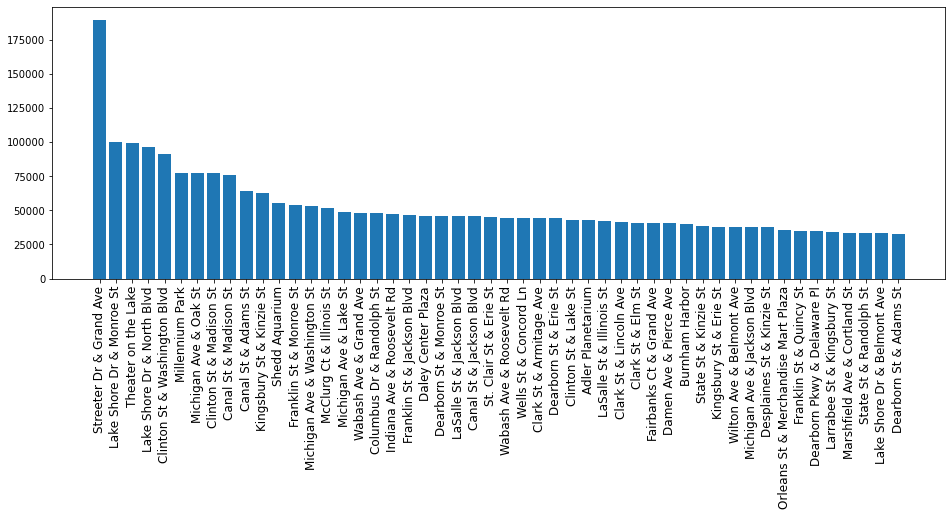

In [278]:
#stations by most activity (started and ended trips)
fig, ax = plt.subplots(figsize=[16,5])
plt.setp(ax.xaxis.get_majorticklabels(),rotation=90,fontsize=12)
ax.bar(activity["station_name"].iloc[:50], activity["activities"].iloc[:50])

<BarContainer object of 50 artists>

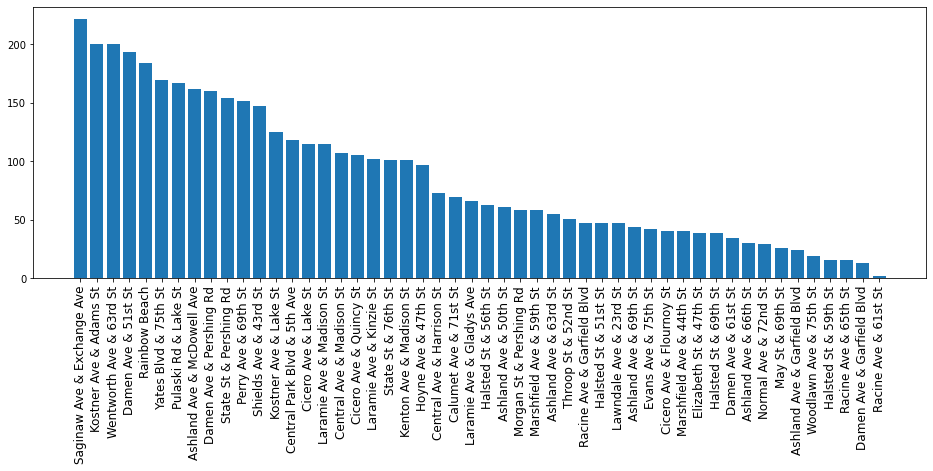

In [284]:
#stations by least activity (started and ended trips)
fig, ax = plt.subplots(figsize=[16,5])
plt.setp(ax.xaxis.get_majorticklabels(),rotation=90,fontsize=12)
ax.bar(activity["station_name"].iloc[-50:], activity["activities"].iloc[-50:])

In [112]:
#most an least used stations on a map
#blue -> least used
#red -> most used
log_map = folium.Map(location=(41.873222041337044, -87.62596070777431),tiles='OpenStreetMap',zoom_start=11, control_scale=True, max_zoom=20)
#add most used
for index, row in activity.iloc[:50].iterrows():
    folium.CircleMarker(radius=5, location=row["ziped_coords"], popup=row["station_name"], color="red", fill_color="red").add_to(log_map)
#add least used
for index, row in activity.iloc[-50:].iterrows():
    folium.CircleMarker(radius=5, location=row["ziped_coords"], popup=row["station_name"], color="blue", fill_color="blue").add_to(log_map)
log_map

## User_type analysis

In [6]:
#analyse data by customer type
chicago_data["user_type"].value_counts()
subscr_data = chicago_data[chicago_data["user_type"] == "Subscriber"]
cust_data = chicago_data[chicago_data["user_type"] == "Customer"]

### Subscribers

In [9]:
#make a activity df from a chicago_2016 style df with coordinates
def asActivity(chicago_dataframe, coordinates):
    start_count = chicago_dataframe["start_station_name"].value_counts()
    end_count = chicago_dataframe["end_station_name"].value_counts()
    activity = start_count.to_frame().merge(end_count, left_on=start_count.index, right_on=end_count.index, how="outer")
    activity = activity.rename(columns={"key_0":"station_name","end_station_name":"finished_trips","start_station_name":"started_trips"})
    #set null values to 0
    activity = activity.fillna(value=0)
    #add activity column
    activity["activities"] = activity["finished_trips"]+activity["started_trips"]

    #add coordinates to stations
    coordinates["ziped_coords"] = list(zip(coordinates["latitude"],coordinates["longitude"]))
    activity = activity.merge(coordinates["ziped_coords"].to_frame(),how = "left",left_on=activity["station_name"],right_on=coordinates["name"])
    activity = activity.drop(columns=["key_0"])
    #drop stations without location data
    activity = activity.dropna(axis=0)
    activity = activity.sort_values(by="activities",ascending=False)
    return activity

In [14]:
#aggregate subscr_data; started trip = ended trip = 1 activity
subscr_activity = asActivity(subscr_data, coordinates)
subscr_activity.head(3)

,station_name,started_trips,finished_trips,activities,ziped_coords
0,Clinton St & Washington Blvd,45907,43054,88961,"(41.883379999999995, -87.64116999999999)"
1,Clinton St & Madison St,39402,33743,73145,"(41.882242, -87.64106600000001)"
2,Canal St & Madison St,33801,37319,71120,"(41.882090999999996, -87.639833)"


<BarContainer object of 50 artists>

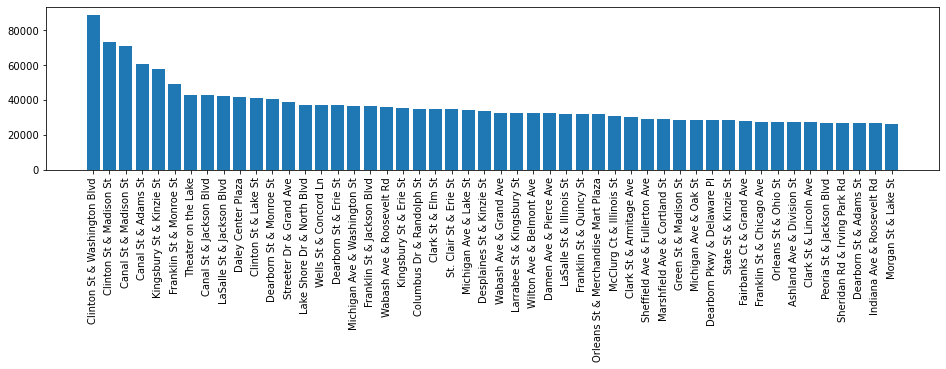

In [17]:
fig, ax = plt.subplots(figsize=[16,3])
plt.setp(ax.xaxis.get_majorticklabels(),rotation=90,fontsize=10)
ax.bar(subscr_activity["station_name"].iloc[:50],subscr_activity["activities"].iloc[:50])

### Customers

In [13]:
#aggregate cust_data; started trip = ended trip = 1 activity
cust_activity = asActivity(cust_data, coordinates)
cust_activity.head(3)

,station_name,started_trips,finished_trips,activities,ziped_coords
0,Streeter Dr & Grand Ave,70921.0,79703.0,150624.0,"(41.892278000000005, -87.612043)"
1,Lake Shore Dr & Monroe St,40467.0,38723.0,79190.0,"(41.880958, -87.616743)"
2,Lake Shore Dr & North Blvd,27711.0,31202.0,58913.0,"(41.911722, -87.626804)"


<BarContainer object of 50 artists>

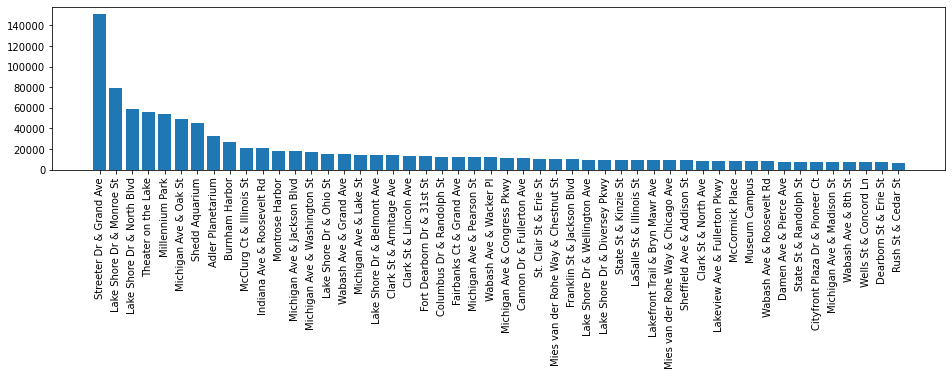

In [30]:
fig, ax = plt.subplots(figsize=[16,3])
plt.setp(ax.xaxis.get_majorticklabels(),rotation=90,fontsize=10)
ax.bar(cust_activity["station_name"].iloc[:50],cust_activity["activities"].iloc[:50])

## Subscriber and Customer stations

In [111]:
#top 50 stations for subscribers and customers

#orange is subscriber
#blue is customer
#stations; size->logarithmic number of activities tours

log_map = folium.Map(location=(41.9, -87.62596070777431),tiles='OpenStreetMap',zoom_start=12, control_scale=True, max_zoom=20)

for index, row in subscr_activity.iloc[:50].iterrows():
    diff_color = "darkorange"
    folium.CircleMarker(radius=np.power(np.log(row["activities"])/4,1.5), location=row["ziped_coords"], popup=row["station_name"], color=diff_color, fill_color=diff_color,weight=2).add_to(log_map)
for index, row in cust_activity.iloc[:50].iterrows():
    diff_color = "blue"
    folium.CircleMarker(radius=np.power(np.log(row["activities"])/4,1.5), location=row["ziped_coords"], popup=row["station_name"], color=diff_color, fill_color=diff_color,weight=2).add_to(log_map)
#prevent jupyter notebook from cutting of map height
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height:unset !important; }</style>"))

log_map

## station bike availibility

Top 100 stations with highest relative difference between started and finished tours. Size is the difference. Green have more trips that end -> bike surplus. Red ones have more trips that start -> bike scarcity

In [105]:
#stations; size->logarithmic difference in trip type
#red ones have more started trips than finished trips
#green ones have more finished trips than started ones

# add difference between started and finished trips
diff_acti = activity
diff_acti["diff"] = np.abs(diff_acti["started_trips"] - diff_acti["finished_trips"])
diff_acti["diff_rel"] = diff_acti["diff"]/diff_acti["activities"]
#filter for reliable data
rel_values = diff_acti[diff_acti["activities"] > 3600]# ~10 uses per day 
rel_values = rel_values.sort_values(by="diff_rel", ascending=False)

diff_map = folium.Map(location=(41.903222041337044, -87.62596070777431),tiles='OpenStreetMap',zoom_start=11, control_scale=True, max_zoom=20)
for index, row in rel_values.iloc[:100].iterrows():
    diff_color = "red" if row["started_trips"] > row["finished_trips"] else "green"
    folium.CircleMarker(radius=row["diff_rel"]*60, location=row["ziped_coords"], popup=row["station_name"]+"; Diff: "+str(row["diff_rel"]), color=diff_color, fill_color=diff_color,weight=2).add_to(diff_map)

#prevent jupyter notebook from cutting of map height
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height:unset !important; }</style>"))
diff_map

## Analysing Stations by weather


In [3]:
#read weatherdata
weather = pd.read_csv(file_path+"/weather_hourly_chicago.csv",parse_dates = ["date_time"])
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43848 entries, 0 to 43847
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date_time  43788 non-null  datetime64[ns]
 1   max_temp   43788 non-null  float64       
 2   min_temp   43788 non-null  float64       
 3   precip     43790 non-null  float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 1.3 MB


In [36]:
#add day of the year feature
weather = weather[weather["date_time"].apply(lambda x:x.year == 2016)]
chicago_data["day_of_year"] = chicago_data["start_time"].apply(lambda x:x.dayofyear)

In [45]:
weather_res = weather.resample("D", on="date_time").agg({'max_temp':'max', 'min_temp': 'min','precip':'sum'})
weather_res["day_of_year"] = weather_res.index.to_series().apply(lambda x:x.dayofyear)
weather_res.value_counts()

max_temp  min_temp  precip  day_of_year
 33.3      25.6     1.0     172            1
 10.0      2.2      0.0     52             1
           5.6      4.0     120            1
                    7.0     119            1
           6.7      2.0     301            1
                                          ..
 25.0      12.2     0.0     143            1
           13.3     0.0     185            1
                            235            1
           14.4     0.0     198            1
-13.9     -20.0     0.0     18             1
Length: 366, dtype: int64

In [53]:
#add weather data to chicago_data
chicago_with_weather = chicago_data.merge(weather_res, right_on=weather_res["day_of_year"], left_on=chicago_data["day_of_year"], how="outer")
chicago_with_weather.head(3)

,key_0,start_time,end_time,start_station_id,end_station_id,start_station_name,end_station_name,bike_id,user_type,day_of_year_x,max_temp,min_temp,precip,day_of_year_y
0,91,2016-03-31 23:53:00,2016-04-01 00:07:00,344,458,Ravenswood Ave & Lawrence Ave,Broadway & Thorndale Ave,155,Subscriber,91,18.9,12.8,8.0,91
1,91,2016-03-31 23:46:00,2016-03-31 23:57:00,128,213,Damen Ave & Chicago Ave,Leavitt St & North Ave,4831,Subscriber,91,18.9,12.8,8.0,91
2,91,2016-03-31 23:42:00,2016-03-31 23:46:00,350,210,Ashland Ave & Chicago Ave,Ashland Ave & Division St,4232,Subscriber,91,18.9,12.8,8.0,91


In [133]:
#aggregate the trips by start_station and temperature intervals on 5 deg
max_temp_stations = chicago_with_weather.groupby([pd.cut(chicago_with_weather["max_temp"], np.arange(-15, 36, 5)), "start_station_name"]).count()
max_temp_stations = max_temp_stations["key_0"]
max_temp_stations = max_temp_stations.dropna()
max_temp_stations = max_temp_stations.to_frame()
max_temp_stations = max_temp_stations.rename(columns={"key_0":"count"})
max_temp_stations.head(3)

MultiIndex([((-15, -10],                '2112 W Peterson Ave'),
            ((-15, -10],                  '900 W Harrison St'),
            ((-15, -10],         'Aberdeen St & Jackson Blvd'),
            ((-15, -10],            'Aberdeen St & Monroe St'),
            ((-15, -10],           'Ada St & Washington Blvd'),
            ((-15, -10],                  'Adler Planetarium'),
            ((-15, -10], 'Albany (Kedzie) Ave & Montrose Ave'),
            ((-15, -10],      'Albany Ave & Bloomingdale Ave'),
            ((-15, -10],          'Artesian Ave & Hubbard St'),
            ((-15, -10],              'Ashland Ave & 13th St'),
            ...
            (  (30, 35],              'Wolcott Ave & Polk St'),
            (  (30, 35],                  'Wood St & 35th St'),
            (  (30, 35],              'Wood St & Division St'),
            (  (30, 35],                'Wood St & Grand Ave'),
            (  (30, 35],            'Wood St & Milwaukee Ave'),
            (  (30, 35],

count
max_temp   start_station_name               
(-15, -10] 2112 W Peterson Ave           1.0
           900 W Harrison St             5.0
           Aberdeen St & Jackson Blvd   26.0

In [116]:
#add coordinates
coordinates["ziped_coords"] = list(zip(coordinates["latitude"],coordinates["longitude"]))
coordinates.head(3)

,id,name,latitude,longitude,dpcapacity,online_date,ziped_coords
0,456,2112 W Peterson Ave,41.991178,-87.683593,15,5/12/2015,"(41.991178000000005, -87.683593)"
1,101,63rd St Beach,41.781016,-87.576120,23,4/20/2015,"(41.781015999999994, -87.57611999999999)"
2,109,900 W Harrison St,41.874675,-87.650019,19,8/6/2013,"(41.874675, -87.650019)"


## Top 75 stations per Max Temperature

Blue = cold temperature, Red = hot temperature. Temperature is divided into intervals of 5 deg fom -15 deg to 35 deg. The map below shows the 75 most used station by started trips for each max temperature per day.

In [176]:
#draw usage map per temp interval
indexes = max_temp_stations.index
log_map = folium.Map(location=(41.873222041337044, -87.62596070777431),tiles='Stamen Toner',zoom_start=12, control_scale=True, max_zoom=20)
#add most used
colors = {
    -14:"#5e4fa2",
    -9:"#3288bd",
    -4:"#66c2a5",
    1:"#abdda4",
    6:"#e6f598",
    11:"#fee08b",
    16:"#fdae61",
    21:"#f46d43",
    26:"#d53e4f",
    31:"#9e0142"
}
for temperature in np.arange(-14, 35, 5):
    df = max_temp_stations.loc[temperature].sort_values(by="count").iloc[-75:]
    #print(df)
    df = df.merge(coordinates["ziped_coords"].to_frame(),left_on=df.index,right_on=coordinates["name"],how="left")
    df = df.dropna()
    for index, row in df.iterrows():
        folium.CircleMarker(radius=6, location=row["ziped_coords"], color=colors[temperature],fill=True,weight=2).add_to(log_map)
log_map

## Analysing by time

In [4]:
#add day of the year feature
weather = weather[weather["date_time"].apply(lambda x:x.year == 2016)]
chicago_data["hour"] = chicago_data["start_time"].apply(lambda x:x.hour)
chicago_data

,start_time,end_time,start_station_id,end_station_id,start_station_name,end_station_name,bike_id,user_type,hour
0,2016-03-31 23:53:00,2016-04-01 00:07:00,344,458,Ravenswood Ave & Lawrence Ave,Broadway & Thorndale Ave,155,Subscriber,23
1,2016-03-31 23:46:00,2016-03-31 23:57:00,128,213,Damen Ave & Chicago Ave,Leavitt St & North Ave,4831,Subscriber,23
2,2016-03-31 23:42:00,2016-03-31 23:46:00,350,210,Ashland Ave & Chicago Ave,Ashland Ave & Division St,4232,Subscriber,23
3,2016-03-31 23:37:00,2016-03-31 23:55:00,303,458,Broadway & Cornelia Ave,Broadway & Thorndale Ave,3464,Subscriber,23
4,2016-03-31 23:33:00,2016-03-31 23:37:00,334,329,Lake Shore Dr & Belmont Ave,Lake Shore Dr & Diversey Pkwy,1750,Subscriber,23
...,...,...,...,...,...,...,...,...,...
3595378,2016-10-01 00:01:08,2016-10-01 00:04:42,56,133,Desplaines St & Kinzie St,Kingsbury St & Kinzie St,3999,Subscriber,0
3595379,2016-10-01 00:00:58,2016-10-01 00:09:33,255,4,Indiana Ave & Roosevelt Rd,Burnham Harbor,2483,Subscriber,0
3595380,2016-10-01 00:00:41,2016-10-01 00:04:19,56,133,Desplaines St & Kinzie St,Kingsbury St & Kinzie St,3892,Subscriber,0
3595381,2016-10-01 00:00:32,2016-10-01 00:16:02,298,460,Lincoln Ave & Belle Plaine Ave,Clark St & Bryn Mawr Ave,3567,Subscriber,0


In [18]:
by_hour = chicago_data["hour"].value_counts().to_frame()
by_hour = by_hour.rename(columns={"hour":"trips"})
by_hour = by_hour.sort_index()

In [22]:
#get weather per trip -> resample chicago_data.start_time to full hours -> merge with weather
#group by weather.count()
weather.head(20)

,date_time,max_temp,min_temp,precip
8736,2016-01-01 01:00:00,-5.0,-5.0,0.0
8737,2016-01-01 02:00:00,-5.0,-5.0,0.0
8738,2016-01-01 03:00:00,-5.6,-5.6,0.0
8739,2016-01-01 04:00:00,-5.0,-5.0,0.0
8740,2016-01-01 05:00:00,-4.4,-4.4,0.0
8741,2016-01-01 06:00:00,-4.4,-4.4,0.0
8759,2016-01-01 00:00:00,-4.4,-4.4,0.0
8760,2016-01-02 01:00:00,-1.1,-1.1,0.0
8761,2016-01-02 02:00:00,-1.1,-1.1,0.0
8762,2016-01-02 03:00:00,-1.7,-1.7,0.0
